This is another example of deploying a CNN, this time on a subset of the Kasthuri data set.  This example is essentially the same as that for ISBI 2012, with a few cosmetic differences.  This script assumes you have already run the kast-train-{synapse,membranes}.py scripts to train the CNN weights.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os, os.path, copy, logging, socket, time

import numpy as np
import pylab as plt

#from ndparse.algorithms import nddl as nddl
#import ndparse as ndp
sys.path.append('..'); import ndparse as ndp

try:
    logger
except:
    # do this precisely once
    logger = logging.getLogger("deploy_kast")
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setFormatter(logging.Formatter('[%(asctime)s:%(name)s:%(levelname)s]  %(message)s'))
    logger.addHandler(ch)

Test data shape is: (100, 1, 1024, 1024)


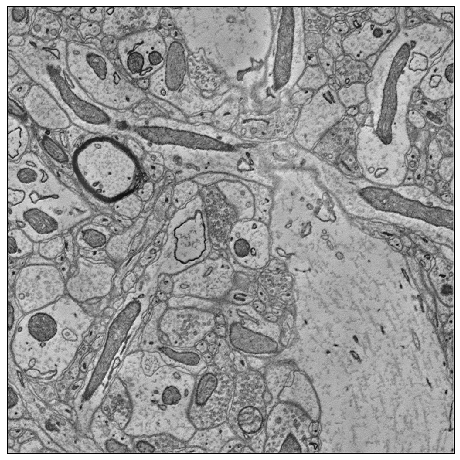

In [10]:
# note: the weight files choosen here are arbitrary.
w_membrane = os.path.join('membrane_weights', 'weights_epoch_001.h5') 
w_synapse = os.path.join('synapse_weights', 'weights_epoch_014.h5')

# load data (from local file - can replace with ndio call if desired)
data = np.load('deep_learning_kasthuri_example_data.npz')
X = data['Xtest']
X = np.transpose(X, [2, 0, 1]).astype(np.float32)
X = X[:,np.newaxis,:,:]

  
# show some details.  Note that data tensors are assumed to have dimensions:
#   (#slices, #channels, #rows, #columns)
#
print('Test data shape is: %s' % str(X.shape))
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(X[0,0,...], interpolation='none', cmap='gray')
#plt.title('test volume, slice 0')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig('ndp_example_image.png')
plt.show()

In [8]:
# In the interest of time, only deploy on one slice (z-dimension) of the test volume 
# *and* only evaluate a subset of the pixels in that slice.
#
# Note: depending upon your system (e.g. CPU vs GPU) this may take a few minutes...
#
tic = time.time()
P_membrane_0 = ndp.nddl.fit(X, w_membrane, s, evalPct=.2, log=logger)
print("Time to deploy: %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_membrane_0.shape))

Using Theano backend.
[2016-11-09 13:22:34,216:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?
[2016-11-09 13:22:34,258:deploy_kast:INFO]  X volume dimensions: (1, 1, 1024, 1024)
[2016-11-09 13:22:34,281:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-09 13:22:34,282:deploy_kast:INFO]  initializing CNN...
[2016-11-09 13:22:35,815:deploy_kast:INFO]  evaluating volume...
[2016-11-09 13:22:39,808:deploy_kast:INFO]  after masking, will evaluate 20.00% of data
[2016-11-09 13:22:41,535:deploy_kast:INFO]    last pixel [  0   0 494] (0.05% complete)
[2016-11-09 13:24:41,727:deploy_kast:INFO]    last pixel [  0  99 617] (9.73% complete)
[2016-11-09 13:26:41,902:deploy_kast:INFO]    last pixel [  0 205 575] (20.07% complete)
[2016-11-09 13:28:42,267:deploy_kast:INFO]    last pixel [  0 303 730] (29.66% complete)
[2016-11-09 13:30:42,493:deploy_kast:INFO]    last pixel [   0  416 1018] (40.72% complete)
[2016-11-09 13:32:42,813:deploy_kast:INFO]    last 

Time to deploy: 1143.38 sec
Class probabilities shape: (1, 2, 1024, 1024)


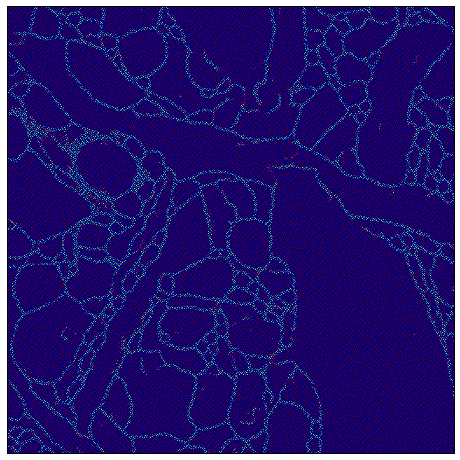

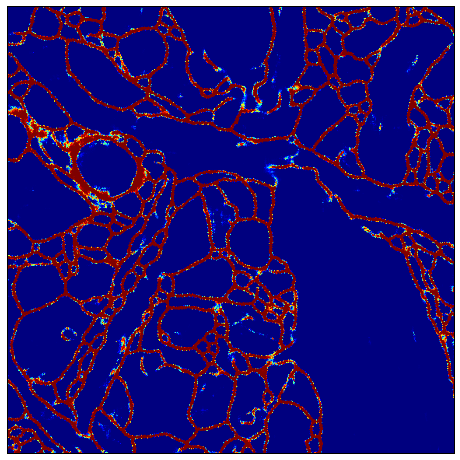

In [14]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
plt.figure(figsize=(8, 8), dpi=300)

P_membrane_int_0 = ndp.nddl.interpolate_nn(P_membrane_0)

# visualize
plt.imshow(P_membrane_0[0,0,...]); #plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig('ndp_example_membrane_sparse.png')
plt.show()
plt.figure(figsize=(8, 8), dpi=300)

plt.imshow(1.0-P_membrane_int_0[0,0,...]);# plt.colorbar()
#plt.title('Class Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig('ndp_example_membrane_full.png')
plt.show()


In [14]:
XX = X[0:30,:,:,:]
print(XX.shape)
tic = time.time()
P_synapse_0 = ndp.nddl.fit(XX, w_synapse, evalPct=.1, log=logger)
print("Time to deploy (synapse): %0.2f sec" % (time.time() - tic))

# The shape of the probability estimate tensor is:
#    (#slices, #classes, #rows, #cols)
print('Class probabilities shape: %s' % str(P_synapse_0.shape))

[2016-11-09 19:03:21,515:deploy_kast:WARNING]  No output file specified - are you sure this is what you want?


(30, 1, 1024, 1024)


[2016-11-09 19:03:22,704:deploy_kast:INFO]  X volume dimensions: (30, 1, 1024, 1024)
[2016-11-09 19:03:22,739:deploy_kast:INFO]  X values min/max:    0, 1
[2016-11-09 19:03:22,740:deploy_kast:INFO]  initializing CNN...
[2016-11-09 19:03:22,891:deploy_kast:INFO]  evaluating volume...
[2016-11-09 19:03:25,764:deploy_kast:INFO]  after masking, will evaluate 10.00% of data
[2016-11-09 19:03:28,543:deploy_kast:INFO]    last pixel [  0   0 989] (0.00% complete)
[2016-11-09 19:05:28,908:deploy_kast:INFO]    last pixel [  0 230 483] (0.75% complete)
[2016-11-09 19:07:29,349:deploy_kast:INFO]    last pixel [  0 484 386] (1.58% complete)
[2016-11-09 19:09:29,792:deploy_kast:INFO]    last pixel [  0 741 212] (2.41% complete)
[2016-11-09 19:11:30,043:deploy_kast:INFO]    last pixel [  0 990 234] (3.22% complete)
[2016-11-09 19:13:30,359:deploy_kast:INFO]    last pixel [  1 187 948] (3.95% complete)
[2016-11-09 19:15:30,749:deploy_kast:INFO]    last pixel [  1 422 297] (4.71% complete)
[2016-11-09 

Time to deploy (synapse): 17313.56 sec
Class probabilities shape: (30, 2, 1024, 1024)


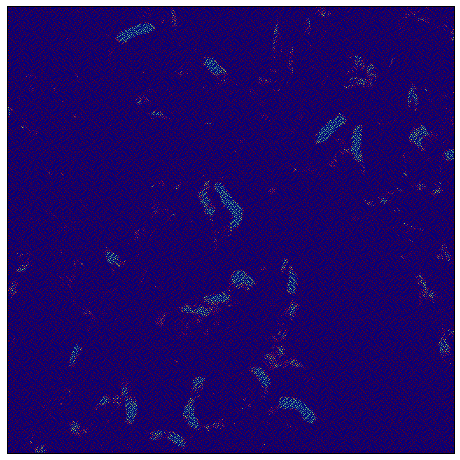

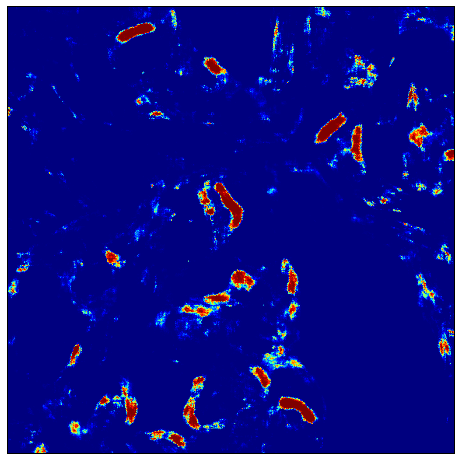

In [15]:
# Use a simple interpolation scheme to fill in "missing" values 
# (i.e. those pixels we did not evaluate using the CNN).
# 
P_synapse_int_0 = ndp.nddl.interpolate_nn(P_synapse_0)
A
# visualize
plt.figure(figsize=(8, 8), dpi=300)

plt.imshow(P_synapse_0[0,0,...]); #plt.colorbar()
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
#plt.title('Synapse Estimates (slice 0, subsampled)')
plt.savefig('ndp_example_synapse_sparse.png')

plt.show()


plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(1-P_synapse_int_0[0,0,...]);# plt.colorbar()
#plt.title('Synapse Estimates: (slice 0, interpolated)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks([])
plt.savefig('ndp_example_synapse_full.png')

plt.show()


In [15]:
import ndparse as ndp
P_synapse_int_0 = ndp.nddl.interpolate_nn(P_synapse_0)

#syn_prob = 1-P_synapse_int_0[0,0,...]
#im = X[0,0,...]

#ss = np.zeros((syn_prob.shape[0],syn_prob.shape[1],1))
#ss[:,:,0] = syn_prob


NameError: name 'ss' is not defined

In [31]:
ss = (np.rollaxis(np.rollaxis(syn,1),2))
im = np.rollaxis(np.rollaxis(X[:,0,:,:],1),2)

In [33]:
im.shape

(1024, 1024, 100)

After processing, there are 60 objects left.


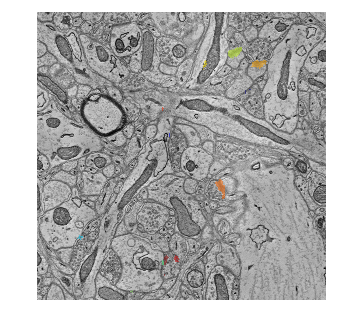

In [40]:
syn = ndp.algorithms.basic_objectify(P_synapse_int_0[:,1,:,:],threshold=0.5,min_size=1000, max_size=10000, remove_speckle=50)
ss = (np.rollaxis(np.rollaxis(syn,1),2))

ndp.plot(im, ss, alpha=0.5, slice=5)

In [41]:
import ndio.remote.neurodata as neurodata
truth = data['Ytest_synapse']
ndp.assess.pr_object(syn,np.rollaxis(np.rollaxis(truth[:,:,0:30],1),2))

0.0166666666667
1.0
0.0327868852459


(0.016666666666666666, 1.0, 0.03278688524590164)

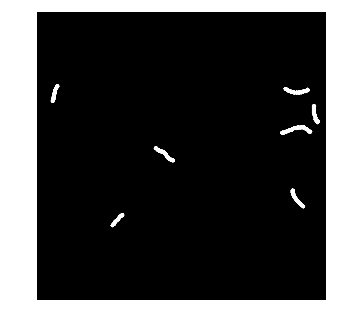

In [36]:
ndp.plot(truth[:,:,0])

In [42]:
np.save('P_synapse_0_slice0_30',P_synapse_0)